# Rt Live Model

In [3]:
%reload_ext autoreload
%autoreload 2

import pymc3 as pm
import pandas as pd
import numpy as np
import arviz as az
import os
#os.chdir(r'C:\Users\hp\covid-model-master')
from matplotlib import pyplot as plt
from covid.models.generative import GenerativeModel
from covid.data import summarize_inference_data
%config InlineBackend.figure_format = 'retina'

from covid.data import get_and_process_covidtracking_data, summarize_inference_data

## Fetch data and select the state's data

In [5]:
df = get_and_process_covidtracking_data(run_date=pd.Timestamp.today()-pd.Timedelta(days=1))

In [6]:
df.head()

positive   total
region                      date                        
Andaman and Nicobar Islands 2020-04-24      15.0  1276.0
                            2020-04-27       6.0   169.0
                            2020-05-01       0.0   906.0
                            2020-05-16       0.0  2923.0
                            2020-05-19       0.0   288.0

In [7]:
region = "Delhi"
model_data = df.loc[region]

## Create the model instance and sample

In [8]:
gm = GenerativeModel(region, model_data)
gm.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 18870 seconds.


## Summarize Model Output

In [9]:
result = summarize_inference_data(gm.inference_data)

In [10]:
result.tail(10)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-07-19,0.855093,0.845777,0.690766,0.977055,417.193710,657.365839,564.598479,1211.0,20206.0
2020-07-20,0.854743,0.847059,0.689532,0.984419,405.984660,635.051825,783.539448,954.0,11470.0
2020-07-21,0.855655,0.846368,0.685590,0.984816,395.275939,613.874893,609.452893,1349.0,20852.0
2020-07-22,0.856442,0.846783,0.691221,0.997943,384.994288,593.769724,576.221613,1227.0,20060.0
2020-07-23,0.857591,0.849795,0.672043,0.998145,375.199656,574.670305,538.065657,1041.0,18226.0
2020-07-24,0.858862,0.855468,0.673855,1.007290,365.948451,556.506557,504.548855,1025.0,19138.0
2020-07-25,0.859949,0.853549,0.673296,1.008956,357.270304,539.210597,524.562848,1142.0,20509.0
2020-07-26,0.860904,0.853190,0.657678,1.011854,349.155188,522.726306,577.601272,1075.0,17533.0
2020-07-27,0.861531,0.852587,0.660335,1.013195,341.556661,507.004744,501.894012,613.0,11506.0


## Plot Model Output

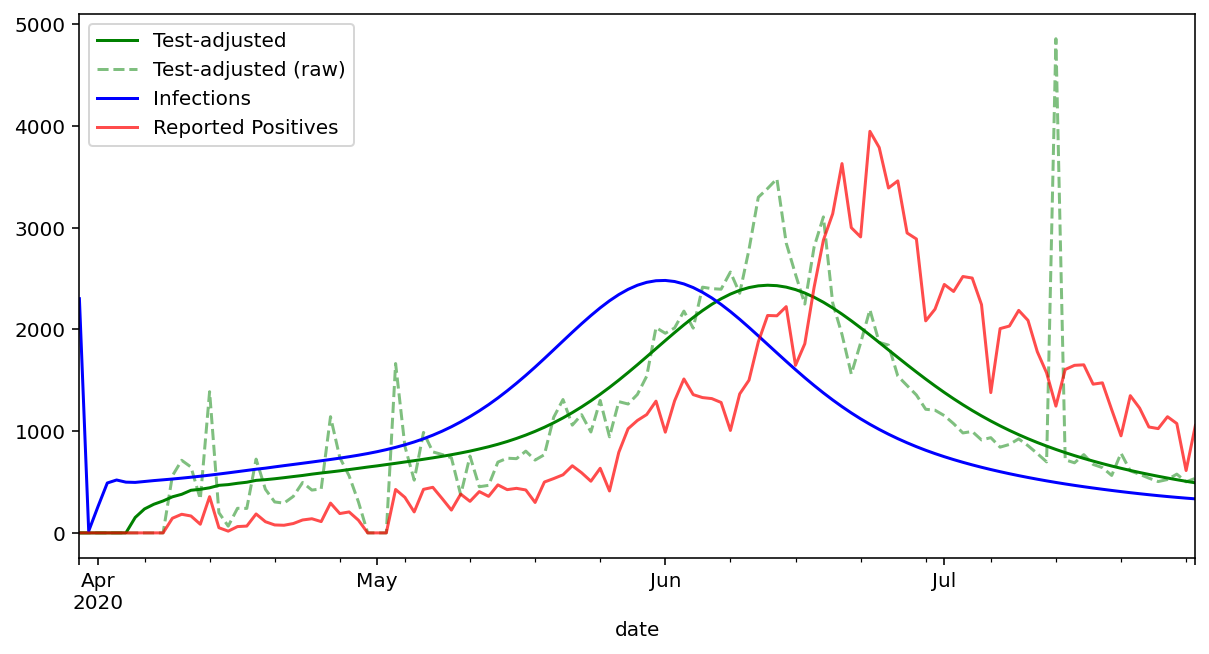

In [11]:
fig, ax = plt.subplots(figsize=(10,5))
result.test_adjusted_positive.plot(c="g", label="Test-adjusted")
result.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
result.infections.plot(c="b", label="Infections")
gm.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
fig.set_facecolor('w')
ax.legend();

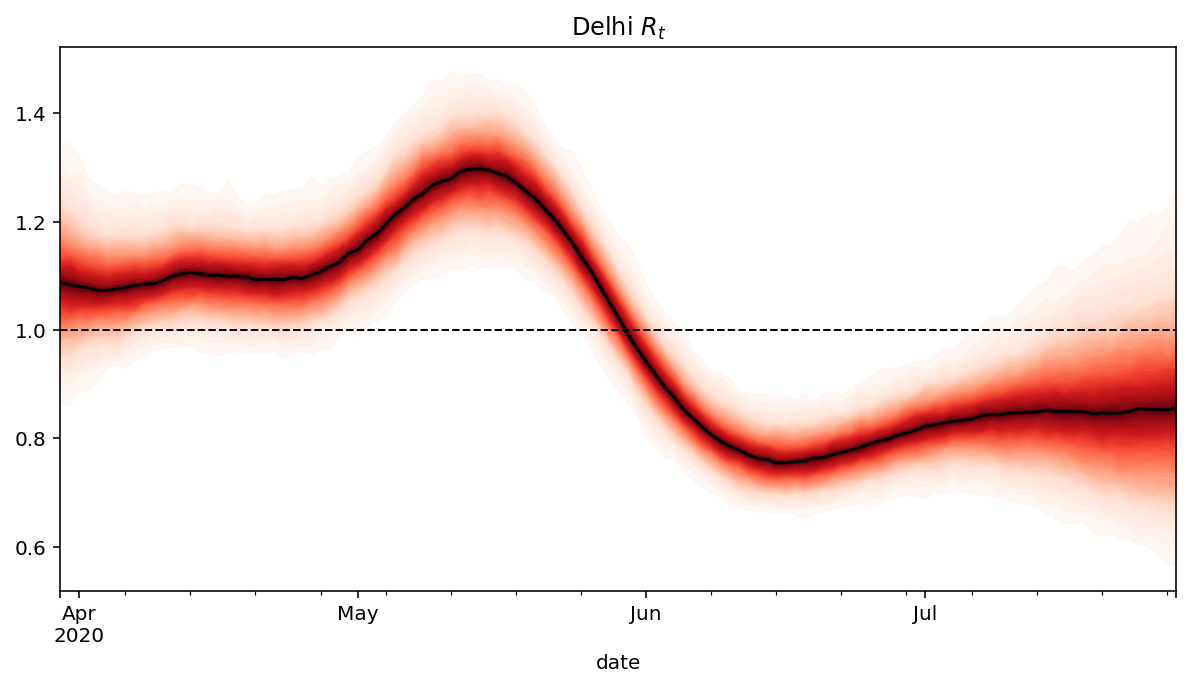

In [12]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"{region} $R_t$")
samples = gm.trace['r_t']
x=result.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

result["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
fig.set_facecolor('w')